## Goal: Determine if population-specific exons have higher Fsts (mean) than shared

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot
import math


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [3]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

## For each population, get the exons that are discovered and the relevant contrasts

In [51]:
# why ?? do i have pop_spec_pop labels for eids that say they're not pop spec? 
# it's just a mistake. I'm using idxmax to call it but not restricting to 
# the entries where pop_spec==True

# here's the problem code -- I'll just set them to NaN for now
# df['n_pop'] = (df>0).sum(axis=1)
# df['pop_spec'] = (df.n_pop==1)&(df[pops]>=2).any(axis=1)
# df['pop_spec_pop'] = df[pops].idxmax(axis=1)

'PEL'

In [53]:
df = pd.read_csv(proc_cfg(config['lr']['exons_pop_spec_ss_fsts_summary'], od),
                 sep='\t')

# set all <0 fsts --> 0 https://www.biostars.org/p/132253/
df.loc[df.fst<0, 'fst'] = 0

# since this is biallelic snp level, remove all exons that didnt intersect
print(len(df.index))
df = df.loc[df.End_b!=-1]
print(len(df.index))

3769828
2299334


In [54]:
# why ?? do i have pop_spec_pop labels for eids that say they're not pop spec? 
# it's just a mistake. I'm using idxmax to call it but not restricting to 
# the entries where pop_spec==True

# here's the problem code -- I'll just set them to NaN for now
# df['n_pop'] = (df>0).sum(axis=1)
# df['pop_spec'] = (df.n_pop==1)&(df[pops]>=2).any(axis=1)
# df['pop_spec_pop'] = df[pops].idxmax(axis=1)

df.loc[df.pop_spec==False, 'pop_spec_pop'] = np.nan

In [55]:
c_dict, order = get_population_colors()

In [56]:
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table.tsv', sep='\t')
exon_df = pd.read_csv(proc_cfg(config['lr']['exon_info'], od), sep='\t')

In [57]:
l2 = len(exon_df.index)
exon_df = exon_df.merge(mt_df[['isoform']+order],
                        how='inner', 
                        left_on='transcript_id',
                        right_on='isoform')
l1 = len(exon_df.index)
assert l1 == l2

In [58]:
df.head()

,Chromosome,Strand,Start,End,novelty,eid,pop_spec,pop_spec_pop,End_b,fst,Start_b,pop1,pop2
269,chr1,+,100007031,100007158,Known,chr1_+_100007033_100007156,False,NaN,100007048,0.393014,100007047,HAC,YRI
270,chr1,+,100043070,100043231,Known,chr1_+_100043072_100043229,False,NaN,100043099,0.041198,100043098,HAC,YRI
271,chr1,+,100043070,100043231,Known,chr1_+_100043072_100043229,False,NaN,100043213,0.000000,100043212,HAC,YRI
272,chr1,+,100049906,100050006,Known,chr1_+_100049908_100050004,False,NaN,100049941,0.018298,100049940,HAC,YRI
273,chr1,+,100140405,100141021,Known,chr1_+_100140407_100141019,False,NaN,100140797,0.047965,100140796,HAC,YRI


PEL
145


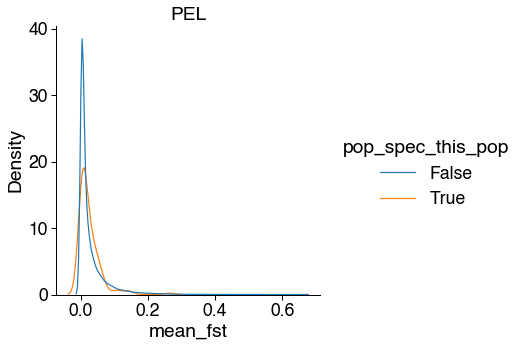

<Figure size 360x360 with 0 Axes>

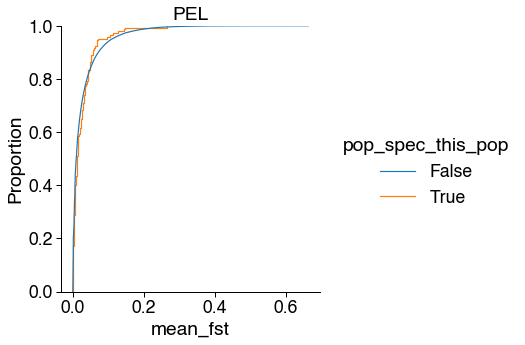

5281516.0
0.18034354470769237
HAC
140


<Figure size 360x360 with 0 Axes>

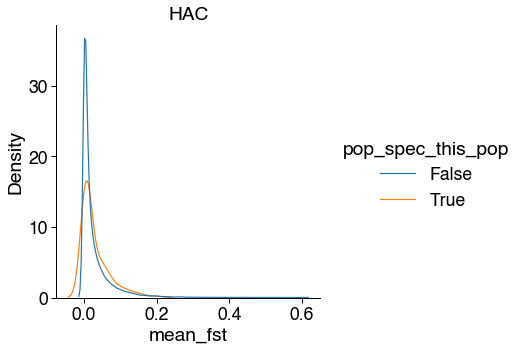

<Figure size 360x360 with 0 Axes>

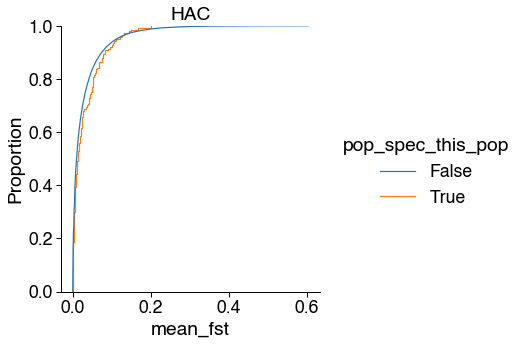

5467535.5
0.07259299021286829
YRI
121


<Figure size 360x360 with 0 Axes>

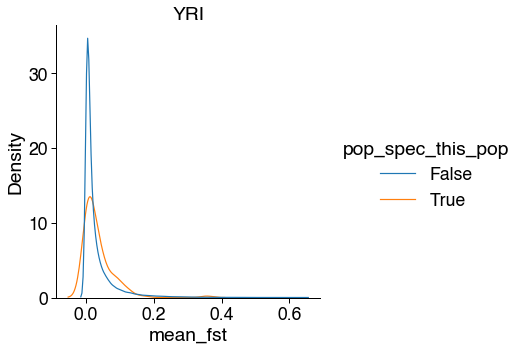

<Figure size 360x360 with 0 Axes>

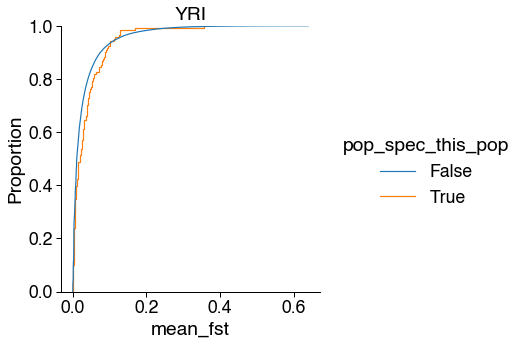

4785054.5
0.014317218713041573
LWK
63


<Figure size 360x360 with 0 Axes>

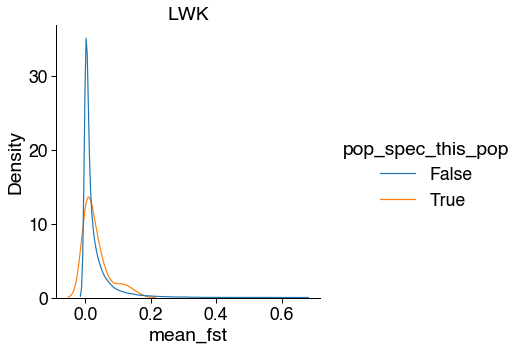

<Figure size 360x360 with 0 Axes>

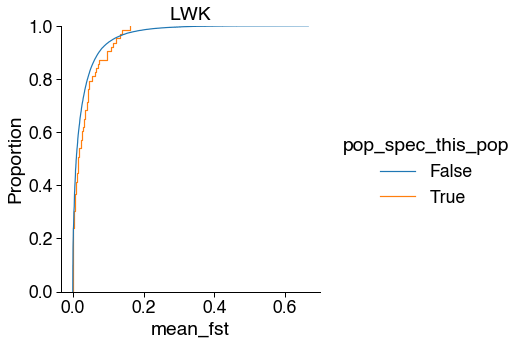

2430163.0
0.06281697219777888
CEU
137


<Figure size 360x360 with 0 Axes>

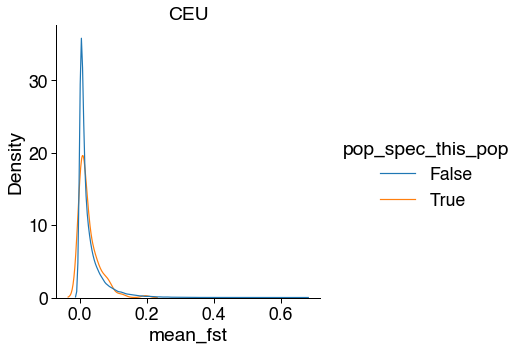

<Figure size 360x360 with 0 Axes>

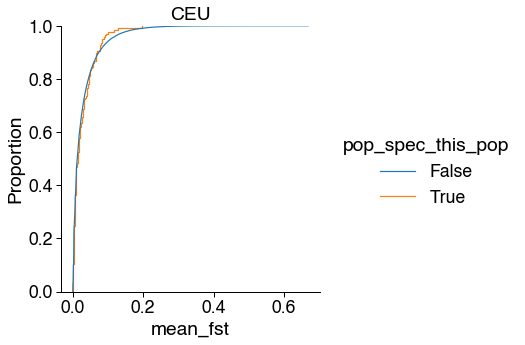

4949177.5
0.3383112085986272
ITU
81


<Figure size 360x360 with 0 Axes>

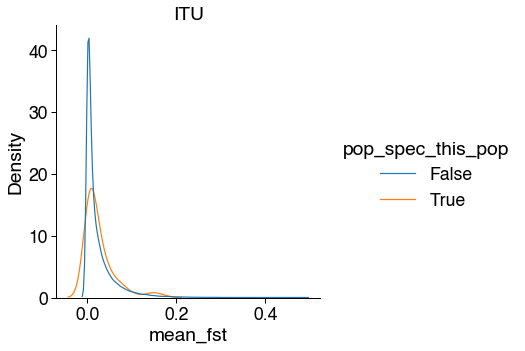

<Figure size 360x360 with 0 Axes>

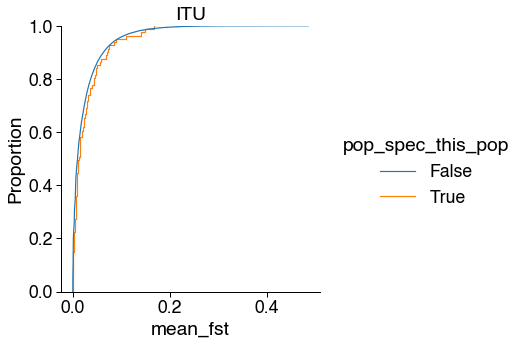

3053526.5
0.04448630892092401


<Figure size 360x360 with 0 Axes>

In [96]:
# loop through each 1000G population
for p in list(set(df.pop1.unique().tolist())|set(df.pop2.unique().tolist())):
    
    print(p)
    
    color = c_dict[p]
    
    # first, limit to all exons discovered in this population
    eids = exon_df.loc[exon_df[p]>0, 'eid'].tolist()
    pop_df = df.loc[df.eid.isin(eids)].copy(deep=True)
    
    # then, limit Fst computations just to contrasts that involve pop
    pop_df = pop_df.loc[(pop_df.pop1==p)|(pop_df.pop2==p)]

#     # just look at the dists. first
#     init_plot_settings()
#     ax = sns.displot(pop_df, 
#                 x='fst',
#                 kind='kde',
#                 color=color)
#     plt.title(p)
#     plt.show()
#     plt.clf()
    
#     init_plot_settings()
#     ax = sns.displot(pop_df, 
#                 x='fst',
#                 kind='ecdf',
#                 color=color) 
#     plt.title(p)
#     plt.show()
#     plt.clf()
    
#     # also plot the std for each exon across contrasts and across 
#     # snps within that eoxn (+-2bp)
#     keep_cols = ['eid', 'fst']
#     std_df = pop_df[keep_cols].groupby('eid').std().reset_index().rename({'fst':'std_fst'}, axis=1)
    
#     init_plot_settings()
#     ax = sns.displot(std_df, 
#                 x='std_fst',
#                 kind='kde',
#                 color=color)
#     plt.title(p)
#     plt.show()
#     plt.clf()
    

#     # plot the Fst dists. for pop-spec and non-pop-spec
#     init_plot_settings()
#     ax = sns.displot(std_df, 
#                 x='std_fst',
#                 kind='ecdf',
#                 color=color) 
#     plt.title(p)
#     plt.show()
#     plt.clf()
    
    
    # for each combination of exon and variant position, get the mean FST
    # (which will be the mean between the contrasts)
    gb_cols = ['eid', 'novelty', 'pop_spec', 'pop_spec_pop']
    keep_cols = gb_cols+['fst']
    pop_df = pop_df[keep_cols].groupby(gb_cols, dropna=False).mean().reset_index().rename({'fst':'mean_fst'}, axis=1)

    # make sure we have no dupe eid combos
    assert len(pop_df.index) == len(pop_df[['eid']].drop_duplicates().index)

    # now assign for each exon whether it's pop-spec in this population
    pop_df['pop_spec_this_pop'] = (pop_df.pop_spec==True)&(pop_df.pop_spec_pop==p)
    
    print(len(pop_df.loc[pop_df.pop_spec_this_pop==True]))

    # plot the Fst dists. for pop-spec and non-pop-spec
    init_plot_settings()
    ax = sns.displot(pop_df, 
                x='mean_fst',
                hue='pop_spec_this_pop',
                kind='kde',
                common_norm=False)  
    plt.title(p)
    plt.show()
    plt.clf()

    # plot the Fst dists. for pop-spec and non-pop-spec
    init_plot_settings()
    ax = sns.displot(pop_df, 
                x='mean_fst',
                hue='pop_spec_this_pop',
                kind='ecdf') 
    plt.title(p)
    plt.show()
    plt.clf()

    x = pop_df.loc[pop_df.pop_spec_this_pop==True,'mean_fst'].tolist() # hyp. --> greater
    y = pop_df.loc[pop_df.pop_spec_this_pop==False,'mean_fst'].tolist()

    # print(f'{pop1} vs {pop2}')
    # print(temp.loc[temp.thing2=='unique','fst'].median())
    # print(temp.loc[temp.thing2=='shared','fst'].median())
    # print()

    stat, pval = st.mannwhitneyu(x, y, alternative='greater')
    print(stat)
    print(pval)

